[Warning] pairing ratio missing for 31 rows (rna_id not found / filtered / RNAfold failed).


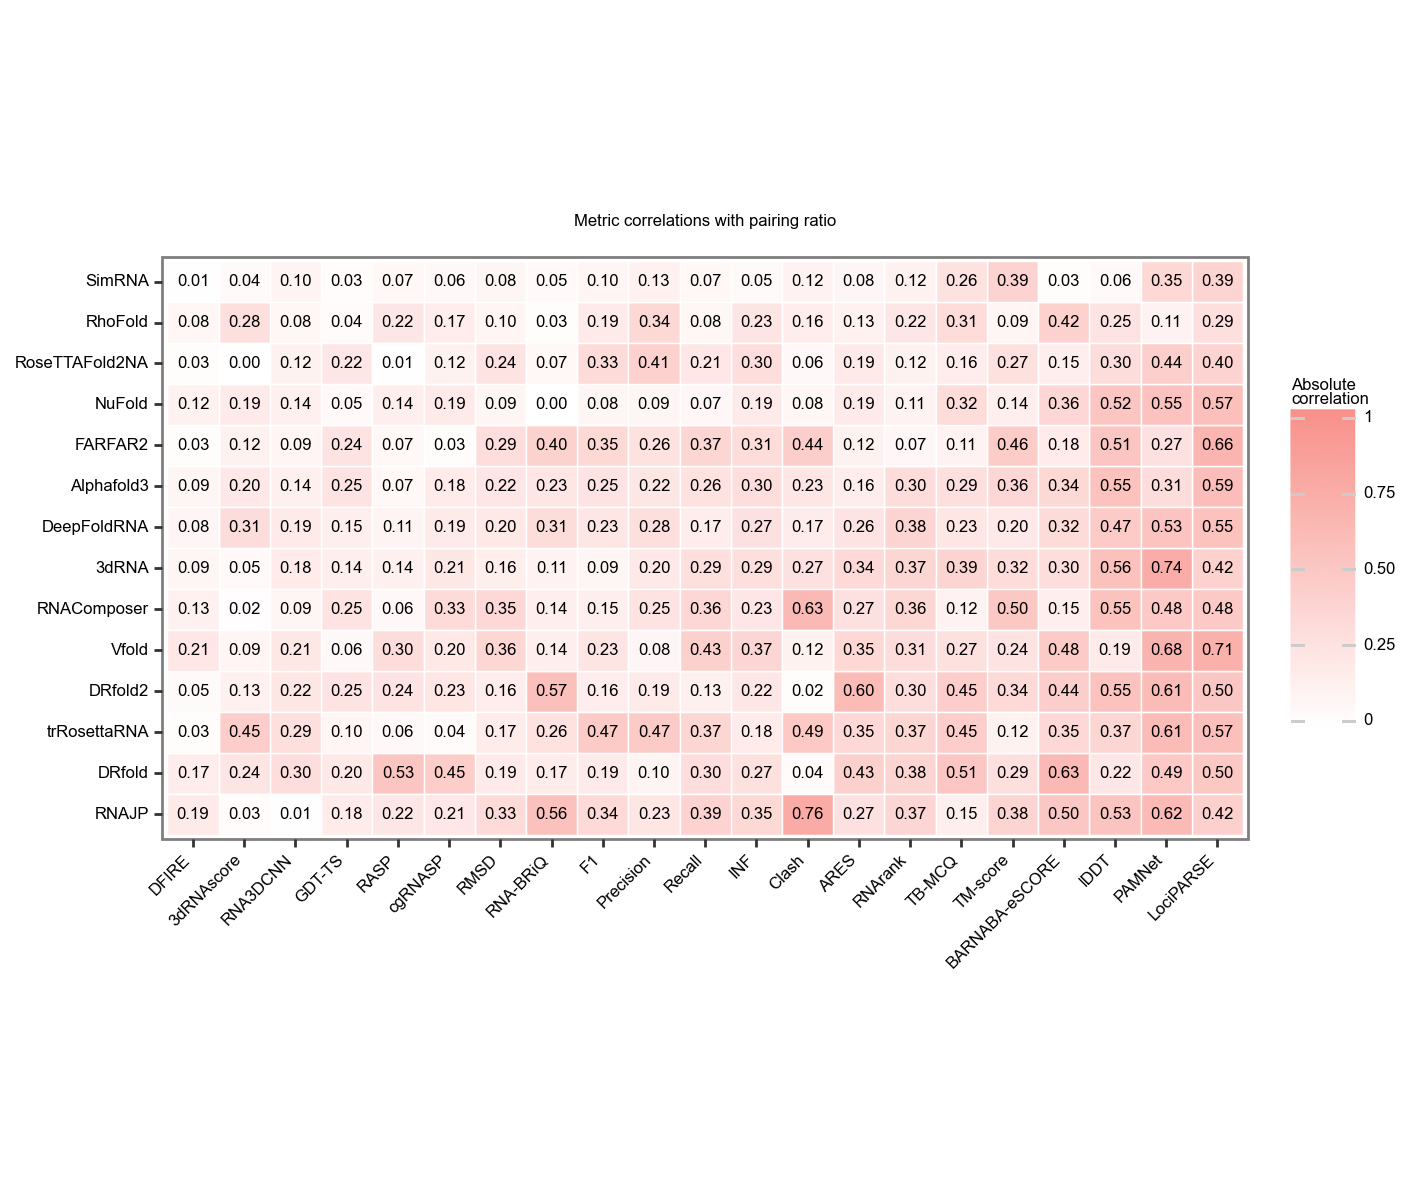

/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7.05 x 6 in image.
/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/metrics_correlation_pair_ratio.pdf


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Heatmap: absolute Pearson correlation between RNA pairing ratio (from RNAfold)
and each evaluation metric, computed separately for each prediction method.

Steps:
1) Load and merge metric tables
2) Extract rna_id from df["rna"]
3) Predict dot-bracket structures with RNAfold for sequences in FASTA files
4) Compute pairing ratio = paired_bases / total_length
5) Map pairing ratio to df
6) For each (method, metric): trim metric outliers (IQR rule) then Pearson r(pair_ratio, metric)
7) Plot heatmap (plotnine) and save as vector PDF

Python 3.8
"""

import os
import shutil
import subprocess
import tempfile
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy import stats
from plotnine import (
    ggplot, aes, geom_tile, geom_text, theme_bw, theme,
    element_text, element_blank, labs, coord_fixed,
    scale_fill_gradient, guides
)


# -------------------------
# Configuration
# -------------------------
DATASET1_CSV = Path("../results/metrics/dataset1_merge.csv")
DATASET2_CSV = Path("../results/metrics/dataset2_merge.csv")
FASTA1 = Path("../datasets/dataset1/dataset1.fasta")
FASTA2 = Path("../datasets/dataset2/dataset2.fasta")
OUT_PDF = Path("../figures/metrics_correlation_pair_ratio.pdf")

FEATURES: List[str] = [
    "RMSD", "lddt", "TM-score", "GDT-TS", "LociPARSE", "RNArank",
    "INF-ALL", "f1", "precision", "recall",
    "BARNABA-eSCORE", "RNA3DCNN", "ARES", "tb_mcq", "PAMnet",
    "clash", "3drnascore", "RNA-BRiQ", "RASP-ENERGY", "DFIRE", "cgRNASP"
]

FEATURE_LABELS: Dict[str, str] = {
    "RMSD": "RMSD",
    "lddt": "lDDT",
    "TM-score": "TM-score",
    "GDT-TS": "GDT-TS",
    "LociPARSE": "LociPARSE",
    "RNArank": "RNArank",
    "INF-ALL": "INF",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
    "BARNABA-eSCORE": "BARNABA-eSCORE",
    "RNA3DCNN": "RNA3DCNN",
    "ARES": "ARES",
    "tb_mcq": "TB-MCQ",
    "PAMnet": "PAMNet",
    "clash": "Clash",
    "3drnascore": "3dRNAscore",
    "RNA-BRiQ": "RNA-BRiQ",
    "RASP-ENERGY": "RASP",
    "DFIRE": "DFIRE",
    "cgRNASP": "cgRNASP"
}

# Pairing ratio settings
MAX_LEN_FOR_RNAFOLD = 5000
RNAFOLD_TIMEOUT_SEC = 30

# Outlier trimming per metric
IQR_K = 5.0

# Plot style
FONT_FAMILY = "Arial"
FONT_SIZE = 6
FIGURE_SIZE_IN = (7.05, 6)
LABEL_FMT = "{:.2f}"


# -------------------------
# Utilities
# -------------------------
def require_columns(df: pd.DataFrame, cols: List[str]) -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")


def extract_rna_id(rna_field: str) -> str:
    """
    Your original rule:
      x.split(".")[2].split("_")[0]
    Safer + explicit.
    """
    if not isinstance(rna_field, str):
        return ""
    parts = rna_field.split(".")
    if len(parts) < 3:
        return ""
    return parts[2].split("_")[0]


def iqr_bounds(x: pd.Series, k: float = 5.0) -> Tuple[float, float]:
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (q1 - k * iqr, q3 + k * iqr)


def safe_pearsonr(x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    """Pearson r with edge-case handling (constant arrays, too few points)."""
    if x.size < 2 or y.size < 2:
        return (np.nan, np.nan)
    try:
        r, p = stats.pearsonr(x, y)
        return float(r), float(p)
    except Exception:
        return (np.nan, np.nan)


def pairing_ratio_from_dotbracket(structure: str) -> float:
    """
    Pairing ratio = paired_bases / total_length.
    Dot-bracket assumed to contain only '()', '.' (RNAfold output).
    """
    if not structure:
        return np.nan
    total = len(structure)
    paired = structure.count("(") + structure.count(")")
    unpaired = structure.count(".")
    # RNAfold dot-bracket should satisfy paired + unpaired == total
    if paired + unpaired != total:
        return np.nan
    return paired / total if total > 0 else np.nan


def run_rnafold_dotbracket(seq_id: str, seq: str) -> str:
    """
    Run RNAfold and return dot-bracket structure (without energy).
    Uses a unique temp file to avoid collisions.
    """
    if shutil.which("RNAfold") is None:
        raise RuntimeError(
            "RNAfold not found in PATH. Please install ViennaRNA and ensure RNAfold is callable."
        )

    # RNAfold expects RNA; convert T->U
    seq = seq.upper().replace("T", "U")

    with tempfile.TemporaryDirectory() as tmpdir:
        fa_path = Path(tmpdir) / "seq.fa"
        fa_path.write_text(f">{seq_id}\n{seq}\n")

        # RNAfold output format typically:
        # line0: >id
        # line1: SEQUENCE
        # line2: DOTBRACKET ( -3.40)
        # But depending on versions, there may be small variations; we parse robustly.
        res = subprocess.run(
            ["RNAfold", "--noPS", str(fa_path)],
            capture_output=True,
            text=True,
            timeout=RNAFOLD_TIMEOUT_SEC,
            check=False,
        )

        if res.returncode != 0:
            # Useful for debugging:
            # print(res.stderr)
            return ""

        lines = [ln.strip() for ln in res.stdout.splitlines() if ln.strip()]
        # Find first line that looks like dot-bracket (contains '.', '(' or ')')
        # and is not the FASTA header or raw sequence.
        for ln in lines:
            if set(ln) <= set("(). 0123456789-") and ("(" in ln or "." in ln):
                # structure is the first token before whitespace / energy
                return ln.split()[0]

        # Fallback: common case is last non-empty line
        if lines:
            return lines[-1].split()[0]
        return ""


def build_pair_ratio_dict(fasta_paths: List[Path]) -> Dict[str, float]:
    """
    Compute pairing ratios for all sequences in the provided FASTA files.
    Returns {record.id: pairing_ratio}.
    """
    ratios: Dict[str, float] = {}

    for fp in fasta_paths:
        if not fp.exists():
            raise FileNotFoundError(f"FASTA not found: {fp}")

        for rec in SeqIO.parse(str(fp), "fasta"):
            seq = str(rec.seq).upper().replace("T", "U")

            if len(seq) > MAX_LEN_FOR_RNAFOLD:
                continue

            dot = run_rnafold_dotbracket(rec.id, seq)
            ratio = pairing_ratio_from_dotbracket(dot)

            if np.isfinite(ratio):
                ratios[rec.id] = float(ratio)

    return ratios


def compute_abs_corr_table(df: pd.DataFrame, covar_col: str) -> pd.DataFrame:
    """
    Compute abs Pearson correlation between covariate (pair ratio) and each metric, per method.
    Returns long-form table:
      Method, Feature, abs_r, p, n
    """
    require_columns(df, ["method", covar_col] + FEATURES)

    methods = sorted(df["method"].dropna().unique().tolist())

    rows = []
    for feat in FEATURES:
        low, high = iqr_bounds(df[feat], k=IQR_K)
        df_feat = df.loc[
            (df[feat] >= low) & (df[feat] <= high),
            ["method", covar_col, feat]
        ].dropna()

        for m in methods:
            sub = df_feat[df_feat["method"] == m]
            n = int(sub.shape[0])

            r, p = safe_pearsonr(sub[covar_col].to_numpy(), sub[feat].to_numpy())

            rows.append({
                "Method": m,
                "Feature_raw": feat,
                "Feature": FEATURE_LABELS.get(feat, feat),
                "n": n,
                "r": r,
                "abs_r": np.abs(r) if np.isfinite(r) else np.nan,
                "p": p
            })

    out = pd.DataFrame(rows)

    # Reorder axes by mean abs correlation
    method_order = (out.groupby("Method")["abs_r"].mean().sort_values(ascending=False).index.tolist())
    feature_order = (out.groupby("Feature")["abs_r"].mean().sort_values(ascending=True).index.tolist())

    out["Method"] = pd.Categorical(out["Method"], categories=method_order, ordered=True)
    out["Feature"] = pd.Categorical(out["Feature"], categories=feature_order, ordered=True)

    out["label"] = out["abs_r"].map(lambda v: "" if pd.isna(v) else LABEL_FMT.format(v))
    out.loc[out["n"] < 2, "label"] = ""

    return out


def plot_heatmap(heatmap_df: pd.DataFrame, title: str, legend: bool = True):
    """
    Publication-style heatmap with a single fill scale (abs_r in [0,1]).
    """
    p = (
        ggplot(heatmap_df, aes(x="Feature", y="Method", fill="abs_r"))
        + geom_tile(color="white", size=0.3)
        + geom_text(aes(label="label"), size=6, family=FONT_FAMILY, color="black")
        + scale_fill_gradient(
            low="white",
            high="#F89089",
            limits=[0, 1],
            name="Absolute\ncorrelation"
        )
        + theme_bw()
        + theme(
            figure_size=FIGURE_SIZE_IN,
            axis_text_x=element_text(rotation=45, hjust=1, size=FONT_SIZE, family=FONT_FAMILY, color="black"),
            axis_text_y=element_text(size=FONT_SIZE, family=FONT_FAMILY, color="black"),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            panel_grid=element_blank(),
            legend_title=element_text(size=FONT_SIZE, family=FONT_FAMILY),
            legend_text=element_text(size=FONT_SIZE, family=FONT_FAMILY),
            plot_title=element_text(hjust=0.5, size=FONT_SIZE, family=FONT_FAMILY, color="black"),
        )
        + labs(title=title)
        + coord_fixed(ratio=0.8)
    )

    
    return p


# -------------------------
# Main
# -------------------------
def main():
    # 1) Load + merge tables
    df1 = pd.read_csv(DATASET1_CSV, index_col=0)
    df2 = pd.read_csv(DATASET2_CSV, index_col=0)
    df = pd.concat([df1, df2], axis=0)

    require_columns(df, ["method", "rna"] + FEATURES)

    # 2) Extract rna_id
    df["rna_id"] = df["rna"].map(extract_rna_id)

    # 3) Predict pairing ratio from FASTA sequences (RNAfold)
    ratio_map = build_pair_ratio_dict([FASTA1, FASTA2])

    # 4) Map pairing ratio onto df
    df["pair_ratio"] = df["rna_id"].map(ratio_map)

    missing = int(df["pair_ratio"].isna().sum())
    if missing > 0:
        print(f"[Warning] pairing ratio missing for {missing} rows (rna_id not found / filtered / RNAfold failed).")

    # 5) Correlation table (pair_ratio vs metric, per method)
    heatmap_df = compute_abs_corr_table(df, covar_col="pair_ratio")

    # 6) Plot + save
    p = plot_heatmap(heatmap_df, title="Metric correlations with pairing ratio", legend=False)
    print(p)

    OUT_PDF.parent.mkdir(parents=True, exist_ok=True)
    p.save(str(OUT_PDF), dpi=300)


if __name__ == "__main__":
    main()
